### Read in IMDB data from IMDB.csv, do some preprocessing by dropping rows that have null values and dropping any duplicate reviews.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
imdb = pd.read_csv("../W13/IMDB.csv")
imdb.dropna(inplace = True)
imdb.drop_duplicates(subset = ["REVIEW", "RATING"], inplace = True)
imdb.head()

,AUTHOR,TITLE,REVIEW,RATING
0,margarida-44311,Not Bad,I don't get all the terrible reviews for this ...,5.0
1,joemay-2,What are all the bad reviews about is it a wo...,I cannot believe anyone could give this film l...,8.0
2,nebk,Great White=Jaws Lite,Great White is not the worst way to spend 90 m...,4.0
3,kuarinofu,Bare-bones killer shark film,Great White is as basic of a killer shark film...,4.0
4,Horror_Flick_Fanatic,"Terrible story, dialogue, and CGI","Terrible story, dialogue and CGI. The film has...",4.0


## Sentiment analysis

In [3]:
import nltk 
# nltk.download('stopwords') 
# nltk.download('punkt') 
# nltk.download('vader_lexicon')

from nltk.sentiment.vader import SentimentIntensityAnalyzer 
from nltk.sentiment.util import * 
from textblob import TextBlob

### 1. Using textblob get the polarity of the rating (Textblob(review).sentiment.polarity).

In [4]:
textblob_polarity = []
for r in imdb["REVIEW"]:
    textblob_polarity.append(TextBlob(r).sentiment.polarity)

imdb["textblob_polarity"] = textblob_polarity

### 2. Using VADER get the probability that a review is positive, negative, or neutral (SenitmentIntensityAnalyzer().polarity_scores(review).

In [5]:
# get VADER polarity scores (positive + neutral + negative + compound)
vader_polarity = []
vader_analyzer = SentimentIntensityAnalyzer()
for r in imdb["REVIEW"]:
    vader_polarity.append(vader_analyzer.polarity_scores(r))

In [6]:
# extract the compound scores from VADER polarity scores
compound_score = []
for vp in vader_polarity:
    compound_score.append(vp["compound"])
    
imdb["compound_score"] = compound_score

In [7]:
imdb.head()

,AUTHOR,TITLE,REVIEW,RATING,textblob_polarity,compound_score
0,margarida-44311,Not Bad,I don't get all the terrible reviews for this ...,5.0,0.021383,-0.5823
1,joemay-2,What are all the bad reviews about is it a wo...,I cannot believe anyone could give this film l...,8.0,0.311111,0.7269
2,nebk,Great White=Jaws Lite,Great White is not the worst way to spend 90 m...,4.0,0.076299,0.9822
3,kuarinofu,Bare-bones killer shark film,Great White is as basic of a killer shark film...,4.0,0.013755,-0.9308
4,Horror_Flick_Fanatic,"Terrible story, dialogue, and CGI","Terrible story, dialogue and CGI. The film has...",4.0,0.038889,0.9294


### 3. For each rating score graph the corresponding average value of textblob polarity and VADER compound score.

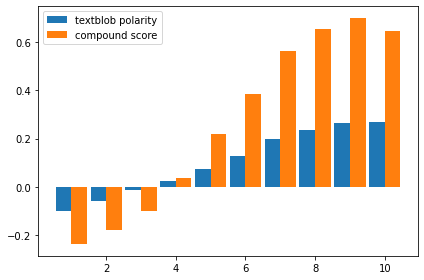

In [8]:
# group by ratings, then show the average TextBlob and VADER compound score
temp = imdb.groupby("RATING")[["textblob_polarity","compound_score"]].mean()

x = np.arange(len(temp.index))+1
width = 0.45
fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, temp["textblob_polarity"], width, label='textblob polarity')
rects2 = ax.bar(x + width/2, temp["compound_score"], width, label='compound score')
ax.legend()
fig.tight_layout()
plt.show()

### 4. Combine the scores and classify each rating as Positive, Negative, or Neutral.

In [9]:
# combined score = (textblob_polarity + compound_score) / 2 
combined_score = list(map(lambda x,y : (x+y)/2, compound_score, textblob_polarity))
classify_score = ["Positive" if cs > 0.05 else "Negative" if cs < -0.05 else "Neutral" for cs in combined_score]
imdb["combined_score"] = combined_score
imdb["classify_score"] = classify_score

In [10]:
imdb.head()

,AUTHOR,TITLE,REVIEW,RATING,textblob_polarity,compound_score,combined_score,classify_score
0,margarida-44311,Not Bad,I don't get all the terrible reviews for this ...,5.0,0.021383,-0.5823,-0.280459,Negative
1,joemay-2,What are all the bad reviews about is it a wo...,I cannot believe anyone could give this film l...,8.0,0.311111,0.7269,0.519006,Positive
2,nebk,Great White=Jaws Lite,Great White is not the worst way to spend 90 m...,4.0,0.076299,0.9822,0.529250,Positive
3,kuarinofu,Bare-bones killer shark film,Great White is as basic of a killer shark film...,4.0,0.013755,-0.9308,-0.458523,Negative
4,Horror_Flick_Fanatic,"Terrible story, dialogue, and CGI","Terrible story, dialogue and CGI. The film has...",4.0,0.038889,0.9294,0.484144,Positive


### 5. Describe your method of combining the ratings and why you choose it.

*I added up Textblob polarity and the compound score from VADER, then divided the sum by two. Since both scores have the range [-1,1], the new range of the combined score would be [-1,1]. For those scores higher than 0.05, I put them as positive, for smaller than -0.05 I put negative, and if equals 0, I put neutral. This classificatin method matches how it is defined in VADER.*  
*This way the polarity of score would not be lost, and the scale can be kept from both methods. Additionally, the polarity is maintained in the result.*

## Tokenizing and stemming

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.decomposition import LatentDirichletAllocation

from nltk.stem.wordnet import WordNetLemmatizer

### 0. Create a Tokenizer function that takes a string and returns the word stems

In [12]:
# string = sentence, turn sentence into word tokens
def tokenizing(sentence):
    tokens = nltk.word_tokenize(sentence)
    return tokens

In [13]:
# remove punctuations
def remove_meaningless(tokens):
    useful_tokens = []
    useful_tokens = [tokens.lower() for tokens in tokens if tokens.isalpha()]
    return useful_tokens

In [14]:
# remove stop words
def remove_stopword(tokens):
    # define stop words
    typical_stopwords = nltk.corpus.stopwords.words('english')
    add_stopwords = {"<br />", "movie", "film"}
    stopwords = add_stopwords.union(typical_stopwords)
    # filter out stop words and keep useful words
    useful_tokens = []
    for t in tokens:
        if t not in stopwords:
            useful_tokens.append(t)
            
    return useful_tokens

In [15]:
# stem words
def stemming(tokens):
    stemmed_tokens=[]
    
    stemmer = nltk.stem.snowball.SnowballStemmer("english")
    for t in tokens:
        stemmed_tokens.append(stemmer.stem(t))
    
    return stemmed_tokens

In [16]:
clean_tokens = []
for r in imdb["REVIEW"]:
    tokens = tokenizing(r)
    punc_free = remove_meaningless(tokens)
    stop_free = remove_stopword(punc_free)
    stemmed_tokens = stemming(stop_free)
    clean_tokens.append(stemmed_tokens)

In [17]:
corpus = [' '.join(t) for t in clean_tokens]

### 1. Using the TfidfVectorizer create a TF-IDF matrix specifying your tokenizer function and your stopwords in the model.

In [18]:
vectorizer_TF_IDF = TfidfVectorizer(norm = None, smooth_idf = True)
TF_IDF_matrix = vectorizer_TF_IDF.fit_transform(corpus).toarray()

In [19]:
pd.DataFrame(np.round(TF_IDF_matrix,2), columns=vectorizer_TF_IDF.get_feature_names()).head()

,aa,aaa,aaaa,aaaaaamaz,aanrad,aaron,aarp,aback,abandon,abbey,...,zone,zoo,zooland,zoom,zoomer,zsjl,zwart,zzzzz,ðÿ,ðÿžÿ
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### 2. Create a LDA model with 6 topics, create a column for the highest weighted topic for each review.

In [20]:
lda_model = LatentDirichletAllocation(n_components=6, random_state=0).fit(TF_IDF_matrix)
pred = lda_model.fit_transform(TF_IDF_matrix)

In [21]:
# find the top weighted topic for each review
for i in range(0,6):
    imdb["topic_{}".format(i+1)] = pred[:,i]
imdb["highest_topic"] = imdb[["topic_1", "topic_2", "topic_3", "topic_4", "topic_5", "topic_6"]].idxmax(axis=1)
imdb.head()

,AUTHOR,TITLE,REVIEW,RATING,textblob_polarity,compound_score,combined_score,classify_score,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,highest_topic
0,margarida-44311,Not Bad,I don't get all the terrible reviews for this ...,5.0,0.021383,-0.5823,-0.280459,Negative,0.179405,0.001183,0.390673,0.426374,0.001181,0.001184,topic_4
1,joemay-2,What are all the bad reviews about is it a wo...,I cannot believe anyone could give this film l...,8.0,0.311111,0.7269,0.519006,Positive,0.003043,0.003039,0.003054,0.984759,0.003053,0.003053,topic_4
2,nebk,Great White=Jaws Lite,Great White is not the worst way to spend 90 m...,4.0,0.076299,0.9822,0.529250,Positive,0.000271,0.921740,0.000272,0.052651,0.024794,0.000272,topic_2
3,kuarinofu,Bare-bones killer shark film,Great White is as basic of a killer shark film...,4.0,0.013755,-0.9308,-0.458523,Negative,0.000424,0.000424,0.000424,0.802590,0.000424,0.195713,topic_4
4,Horror_Flick_Fanatic,"Terrible story, dialogue, and CGI","Terrible story, dialogue and CGI. The film has...",4.0,0.038889,0.9294,0.484144,Positive,0.000868,0.000869,0.000869,0.995658,0.000869,0.000867,topic_4


### 3. Combine the sentiment and topic datasets, create a chart with average sentiment and average review score by topic. Ensure that the axes are scaled to make the graph easy to read.

In [22]:
# datasets combined already in previous steps

In [23]:
temp2 = imdb.groupby("highest_topic")[["combined_score", "RATING"]].mean()
temp2["sentiment_norm"] = temp2["combined_score"].map(lambda x: (x +1) / 2)
temp2["rating_norm"] = temp2["RATING"].map(lambda x: (x -1) / (10-1))
temp2

,combined_score,RATING,sentiment_norm,rating_norm
highest_topic,,,,
topic_1,0.373404,7.428846,0.686702,0.714316
topic_2,0.195085,5.845735,0.597543,0.538415
topic_3,0.002161,3.613728,0.501080,0.290414
topic_4,0.277467,6.320734,0.638734,0.591193
topic_5,-0.020893,3.166052,0.489553,0.240672
topic_6,0.313074,6.764414,0.656537,0.640490


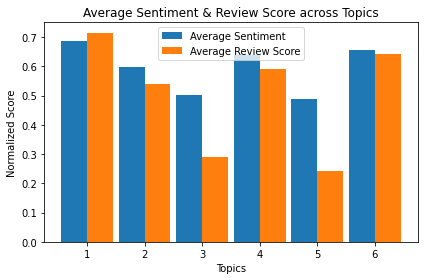

In [24]:
x = np.arange(len(temp2.index))+1  # the label locations
width = 0.45  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, temp2["sentiment_norm"], width, label='Average Sentiment')
rects2 = ax.bar(x + width/2, temp2["rating_norm"], width, label='Average Review Score')
ax.legend()
ax.set_xlabel("Topics")
ax.set_ylabel("Normalized Score")
ax.set_title("Average Sentiment & Review Score across Topics")
fig.tight_layout()
plt.show()

### 4. Create a dataset of the 20 words with the highest weights on each topic

In [25]:
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic %d:" % (topic_idx+1))
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

In [26]:
no_top_words = 20
display_topics(lda_model, vectorizer_TF_IDF.get_feature_names(), no_top_words)

Topic 1:
dig stori hampton black charact fienn fred perform ralph one mulligan beauti peopl great excav love histori war interest fbi
Topic 2:
cage like one get fun good charact turn love famili peopl look realli wrong show even kill sequel animatron origin
Topic 3:
bad like watch good action time make movi act even liam realli funni charact get one neeson could stori scene
Topic 4:
horror like end one good saw first realli charact well movi watch see great would stori thought much time get
Topic 5:
book clanci tom plot read one even action watch like charact make time would seal stori name wast remors bad
Topic 6:
perform malcolm feel charact mari day one like zendaya billi scene realli make washington great watch thing time holiday stori


### 5. Use the top 20 words and the sentiment to describe each topic

- *__topic 1__: has the strongest (highest) sentiment and highest rating. Considering keywords like "fbi", "war", "love", "histori", I think this might be talking about the motion, exicitment aspects of the movies.*
- *__topic 2__: also has high sentiment. It includes some keywords like family, cage and kill, so maybe this is related to suspense movies, or a more bloody aspect of movies.*
- *__topic 3__: has neutral sentiment. Keywords are like "bad", but also "like", "good", "funni".*
- *__topic 4__: has relatively high (positive) sentiment but neutral rating. It includes many good words such as "well", "great", and "good", which correponds to positive sentiment. It could be taking about the characters in the movie.*
- *__topic 5__: has the lowest (negtive) sentiment and rating. It looks like this topic is related to movie stories and emotions.*
- *__topic 6__: relatively high, positive sentiment and rating. Looks like this is about actors, as names like "billi", "malcolm", "washinton" and "zendaya" appears as the topic top words.*